# Deep Q-Networks
[Based on @MorvanZhou tutorial on github](https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow)

In this tutorial we implement Deep Q-Networks and run the model in OpenAI's MountainCar-v0 environment 


![alt text](https://cdn-images-1.medium.com/max/1200/1*8coZ4g_pRtfyoHmsuzMH6g.png)

In [1]:
#Installing OpenAI gym environment (https://github.com/openai/gym)
!pip install gym

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
          t_params = tf.get_collection('target_net_params')
          e_params = tf.get_collection('eval_net_params')
          self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

          self.sess.run(self.replace_target_op)

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # state after transition
                self.s: batch_memory[:, :self.n_features],  # state before transition
            })


        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int) #obtaining action performed
        reward = batch_memory[:, self.n_features + 1] #obtaining reward for the action

        # change q_target for actions taken
        q_target = q_eval.copy()
        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]
        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]
        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.loss_val = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1
        return self.loss_val


In [3]:
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

env = gym.make('MountainCar-v0')
#There are 3 actions: push left, no push and push right
n_actions = 3
#There are 2 features: position and velocity
n_features = 2
env = env.unwrapped
MEMORY_SIZE = 1000

def train(RL, n_episodes):
    total_steps = 0
    steps = []
    reward_history = []
    loss_history = []

    for i_episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        episode_steps = 0
        while True:
            # env.render()

            action = RL.choose_action(observation)

            observation_, reward, done, info = env.step(action)
            episode_reward = episode_reward + reward

            RL.store_transition(observation, action, reward, observation_)

            if total_steps > MEMORY_SIZE:
              loss = RL.learn()
              loss_history.append(loss)

            if done:
                print('episode ', i_episode, ' finished')
                steps.append(episode_steps)
                reward_history.append(episode_reward)
                break

            observation = observation_
            total_steps += 1
            episode_steps += 1
    return steps, loss_history, reward_history
  
RL = DeepQNetwork(n_actions, n_features,
                  learning_rate=0.01,
                  reward_decay=0.9,
                  e_greedy=0.9,
                  replace_target_iter=200,
                  memory_size=2000,
                  # output_graph=True
                  )

n_episodes = 30
steps, loss_history, reward_history = train(RL, n_episodes)



c:\users\patrick\envs\course\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


episode  0  finished
episode  1  finished
episode  2  finished
episode  3  finished
episode  4  finished
episode  5  finished
episode  6  finished
episode  7  finished
episode  8  finished
episode  9  finished
episode  10  finished
episode  11  finished
episode  12  finished
episode  13  finished
episode  14  finished
episode  15  finished
episode  16  finished
episode  17  finished
episode  18  finished
episode  19  finished
episode  20  finished
episode  21  finished
episode  22  finished
episode  23  finished
episode  24  finished
episode  25  finished
episode  26  finished
episode  27  finished
episode  28  finished
episode  29  finished


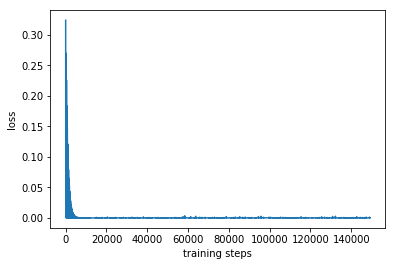

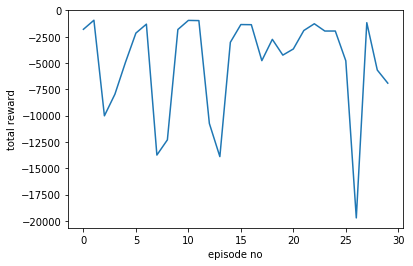

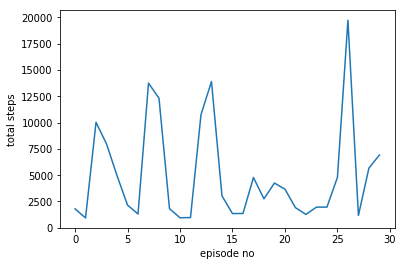

In [4]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_history)), loss_history)
plt.ylabel('loss')
plt.xlabel('training steps')
plt.show()

plt.plot(np.arange(len(reward_history)), reward_history)
plt.ylabel('total reward')
plt.xlabel('episode no')
plt.show()

plt.plot(np.arange(len(steps)), steps)
plt.ylabel('total steps')
plt.xlabel('episode no')
plt.show()

